Data Wrangling : We RateDogs Twitter Data

In [4]:
#import required libraries

import pandas as pd
import numpy as np
import requests
import os
import re
import json
import datetime
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Data Gathering

In [5]:
#twitter archive
#reading csv file
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')


In [6]:
#image prediction
#download URL

url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)


In [7]:
#get file name
file_name = url.split('/')[-1]
file_name

'image-predictions.tsv'

In [8]:
if not os.path.isfile(file_name):
    with open(file_name , mode="wb") as file:
       file.write(response.content)

In [9]:
#reading TSV file
image_predictions = pd.read_csv('image-predictions.tsv' , sep='\t')


In [10]:
#tweet data
df_list = []

with open('tweet-json.txt', 'r') as file:
    for line in file:
        tweet = json.loads(line)
        tweet_id = tweet['id']
        retweet_count = tweet['retweet_count']
        fav_count = tweet['favorite_count']
        df_list.append({'tweet_id':tweet_id,
                       'retweet_count': retweet_count,
                       'favorite_count': fav_count})

#load tweet data into pandas dataframe
tweet_data = pd.DataFrame(df_list)


Data Assessing

inspecting the dataset for:
- data quality issues
- tidiness issues

twitter archive

visual assessment

In [11]:
twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


programmatic assessment

In [12]:
twitter_archive.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
680,788908386943430656,NaN,NaN,2016-10-20 01:03:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Lucy. She destroyed not one, but two r...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/788908386...,11,10,Lucy,None,None,None,None
890,759566828574212096,NaN,NaN,2016-07-31 01:50:18 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This... is a Tyrannosaurus rex....,7.395441e+17,4.196984e+09,2016-06-05 19:47:03 +0000,https://twitter.com/dog_rates/status/739544079...,10,10,None,None,None,None,None
1533,689999384604450816,NaN,NaN,2016-01-21 02:34:07 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Covach. He's trying to melt the snow. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/689999384...,10,10,Covach,None,None,None,None
1496,692530551048294401,NaN,NaN,2016-01-28 02:12:04 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Cody. He's been to like 80 countr...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/692530551...,10,10,Cody,None,None,None,None
610,797236660651966464,NaN,NaN,2016-11-12 00:36:46 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Pancake. She loves Batman and winks li...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/797236660...,12,10,Pancake,None,None,None,None
493,813202720496779264,NaN,NaN,2016-12-26 02:00:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a doggo who has concluded that Christma...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/813202720...,11,10,None,doggo,None,None,None
142,864279568663928832,NaN,NaN,2017-05-16 00:41:21 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Meatball. He doing what's known in the...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/864279568...,12,10,Meatball,None,None,None,None
1227,713909862279876608,NaN,NaN,2016-03-27 02:05:49 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",This is Doug. His nose is legendary af. 12/10 ...,NaN,NaN,NaN,https://vine.co/v/iDWlapaXWmm,12,10,Doug,None,None,None,None
1197,717009362452090881,NaN,NaN,2016-04-04 15:22:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Smokey. He's having some sort of exist...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/717009362...,10,10,Smokey,None,None,pupper,None
1236,712438159032893441,NaN,NaN,2016-03-23 00:37:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Kane. He's a semi-submerged Haitian Hu...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/712438159...,11,10,Kane,None,None,None,None


In [13]:
twitter_archive.shape

(2356, 17)

In [14]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [15]:
twitter_archive[['rating_numerator','rating_denominator']].describe()

,rating_numerator,rating_denominator
count,2356.000000,2356.000000
mean,13.126486,10.455433
std,45.876648,6.745237
min,0.000000,0.000000
25%,10.000000,10.000000
50%,11.000000,10.000000
75%,12.000000,10.000000
max,1776.000000,170.000000


In [16]:
#checking for duplicates
twitter_archive.duplicated().sum()

0

In [17]:
twitter_archive[[ 'doggo', 'floofer', 'pupper', 'puppo']]

,doggo,floofer,pupper,puppo
0,None,None,None,None
1,None,None,None,None
2,None,None,None,None
3,None,None,None,None
4,None,None,None,None
5,None,None,None,None
6,None,None,None,None
7,None,None,None,None
8,None,None,None,None
9,doggo,None,None,None


In [18]:
twitter_archive['name'].value_counts()

None         745
a             55
Charlie       12
Cooper        11
Oliver        11
Lucy          11
Tucker        10
Lola          10
Penny         10
Winston        9
Bo             9
Sadie          8
the            8
Buddy          7
an             7
Daisy          7
Bailey         7
Toby           7
Scout          6
Milo           6
Stanley        6
Rusty          6
Bella          6
Leo            6
Jax            6
Oscar          6
Dave           6
Koda           6
Jack           6
George         5
            ... 
Tuco           1
Rueben         1
Pippin         1
Lenox          1
Eleanor        1
Sage           1
Karl           1
Shiloh         1
Cal            1
Erik           1
Bluebert       1
Sparky         1
Fwed           1
Jangle         1
Ivar           1
Maude          1
Shnuggles      1
Laika          1
Tom            1
Champ          1
Tango          1
Buddah         1
Moofasa        1
Mark           1
Puff           1
Samsom         1
Millie         1
Sweets        

image predictions


visual assessment

In [19]:
image_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


programmatic assessment

In [20]:
image_predictions.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1049,713761197720473600,https://pbs.twimg.com/media/CefKBOuWIAAIlKD.jpg,1,Brittany_spaniel,0.797936,True,English_springer,0.044718,True,Welsh_springer_spaniel,0.037911,True
255,670755717859713024,https://pbs.twimg.com/media/CU8AwZ_UsAA-Lbu.jpg,1,keeshond,0.994065,True,Norwegian_elkhound,0.001827,True,cairn,0.001821,True
421,674045139690631169,https://pbs.twimg.com/media/CVqwedgXIAEAT6A.jpg,1,robin,0.369661,False,rhinoceros_beetle,0.110607,False,European_fire_salamander,0.043178,False
864,697270446429966336,https://pbs.twimg.com/media/Ca0zxGjW8AEfyYl.jpg,1,toy_poodle,0.880014,True,miniature_poodle,0.100136,True,Norfolk_terrier,0.007027,True
1623,803638050916102144,https://pbs.twimg.com/ext_tw_video_thumb/80363...,1,Labrador_retriever,0.372776,True,golden_retriever,0.343666,True,Great_Pyrenees,0.067242,True
131,668297328638447616,https://pbs.twimg.com/media/CUZE4IWW4AAZmDf.jpg,1,king_penguin,0.606747,False,ice_bear,0.264221,False,Eskimo_dog,0.032784,True
1750,823939628516474880,https://pbs.twimg.com/media/C284uD8WgAEmMVn.jpg,1,schipperke,0.234076,True,curly-coated_retriever,0.193093,True,Labrador_retriever,0.095197,True
98,667766675769573376,https://pbs.twimg.com/media/CURiQMnUAAAPT2M.jpg,1,fire_engine,0.883493,False,tow_truck,0.074734,False,jeep,0.012773,False
789,690597161306841088,https://pbs.twimg.com/media/CZV-c9NVIAEWtiU.jpg,1,Lhasa,0.097500,True,koala,0.091934,False,sunglasses,0.091505,False
1824,835152434251116546,https://pbs.twimg.com/media/C5cOtWVWMAEjO5p.jpg,3,swing,0.967066,False,American_Staffordshire_terrier,0.012731,True,Staffordshire_bullterrier,0.007039,True


In [21]:
image_predictions.shape

(2075, 12)

In [22]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [23]:
image_predictions[['p1_conf','p2_conf','p3_conf']].describe()

,p1_conf,p2_conf,p3_conf
count,2075.000000,2.075000e+03,2.075000e+03
mean,0.594548,1.345886e-01,6.032417e-02
std,0.271174,1.006657e-01,5.090593e-02
min,0.044333,1.011300e-08,1.740170e-10
25%,0.364412,5.388625e-02,1.622240e-02
50%,0.588230,1.181810e-01,4.944380e-02
75%,0.843855,1.955655e-01,9.180755e-02
max,1.000000,4.880140e-01,2.734190e-01


In [24]:
#checking for duplicates
image_predictions.duplicated().sum()


0

In [25]:
image_predictions.loc[(image_predictions['p1_dog'] == False) & 
                        (image_predictions['p2_dog'] == False) &
                        (image_predictions['p3_dog'] == False) ]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,4.588540e-02,False,terrapin,1.788530e-02,False
17,666104133288665088,https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg,1,hen,0.965932,False,cock,3.391940e-02,False,partridge,5.206580e-05,False
18,666268910803644416,https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg,1,desktop_computer,0.086502,False,desk,8.554740e-02,False,bookcase,7.947970e-02,False
21,666293911632134144,https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg,1,three-toed_sloth,0.914671,False,otter,1.525000e-02,False,great_grey_owl,1.320720e-02,False
25,666362758909284353,https://pbs.twimg.com/media/CT9lXGsUcAAyUFt.jpg,1,guinea_pig,0.996496,False,skunk,2.402450e-03,False,hamster,4.608630e-04,False
29,666411507551481857,https://pbs.twimg.com/media/CT-RugiWIAELEaq.jpg,1,coho,0.404640,False,barracouta,2.714850e-01,False,gar,1.899450e-01,False
45,666786068205871104,https://pbs.twimg.com/media/CUDmZIkWcAAIPPe.jpg,1,snail,0.999888,False,slug,5.514170e-05,False,acorn,2.625800e-05,False
50,666837028449972224,https://pbs.twimg.com/media/CUEUva1WsAA2jPb.jpg,1,triceratops,0.442113,False,armadillo,1.140710e-01,False,common_iguana,4.325530e-02,False
51,666983947667116034,https://pbs.twimg.com/media/CUGaXDhW4AY9JUH.jpg,1,swab,0.589446,False,chain_saw,1.901420e-01,False,wig,3.450970e-02,False
53,667012601033924608,https://pbs.twimg.com/media/CUG0bC0U8AAw2su.jpg,1,hyena,0.987230,False,African_hunting_dog,1.260080e-02,False,coyote,5.735010e-05,False


In [26]:
image_predictions['p1'].value_counts()

golden_retriever             150
Labrador_retriever           100
Pembroke                      89
Chihuahua                     83
pug                           57
chow                          44
Samoyed                       43
toy_poodle                    39
Pomeranian                    38
malamute                      30
cocker_spaniel                30
French_bulldog                26
miniature_pinscher            23
Chesapeake_Bay_retriever      23
seat_belt                     22
Siberian_husky                20
German_shepherd               20
Staffordshire_bullterrier     20
web_site                      19
Cardigan                      19
teddy                         18
Maltese_dog                   18
Eskimo_dog                    18
Shetland_sheepdog             18
beagle                        18
Shih-Tzu                      17
Lakeland_terrier              17
Rottweiler                    17
kuvasz                        16
Italian_greyhound             16
          

In [27]:
image_predictions['p2'].value_counts()

Labrador_retriever                104
golden_retriever                   92
Cardigan                           73
Chihuahua                          44
Pomeranian                         42
Chesapeake_Bay_retriever           41
French_bulldog                     41
toy_poodle                         37
cocker_spaniel                     34
Siberian_husky                     33
miniature_poodle                   33
beagle                             28
collie                             27
Eskimo_dog                         27
Pembroke                           27
kuvasz                             26
Italian_greyhound                  22
Pekinese                           21
American_Staffordshire_terrier     21
miniature_pinscher                 20
malinois                           20
Samoyed                            20
toy_terrier                        20
chow                               20
Norwegian_elkhound                 19
Boston_bull                        19
Staffordshir

In [28]:
image_predictions['p3'].value_counts()

Labrador_retriever                79
Chihuahua                         58
golden_retriever                  48
Eskimo_dog                        38
kelpie                            35
kuvasz                            34
chow                              32
Staffordshire_bullterrier         32
beagle                            31
cocker_spaniel                    31
toy_poodle                        29
Pomeranian                        29
Pekinese                          29
Great_Pyrenees                    27
Pembroke                          27
Chesapeake_Bay_retriever          27
French_bulldog                    26
malamute                          26
American_Staffordshire_terrier    24
Cardigan                          23
pug                               23
basenji                           21
toy_terrier                       20
bull_mastiff                      20
Siberian_husky                    19
Shetland_sheepdog                 17
Boston_bull                       17
d

In [29]:
image_predictions['img_num'].value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

tweet data 

visual assessment

In [30]:
tweet_data

,favorite_count,retweet_count,tweet_id
0,39467,8853,892420643555336193
1,33819,6514,892177421306343426
2,25461,4328,891815181378084864
3,42908,8964,891689557279858688
4,41048,9774,891327558926688256
5,20562,3261,891087950875897856
6,12041,2158,890971913173991426
7,56848,16716,890729181411237888
8,28226,4429,890609185150312448
9,32467,7711,890240255349198849


programmatic assessment

In [31]:
tweet_data.sample(10)

,favorite_count,retweet_count,tweet_id
876,7343,2210,760656994973933572
1656,3736,1034,683111407806746624
2211,265,62,668567822092664832
818,6987,2390,770414278348247044
1104,13745,7102,734787690684657664
1682,1923,499,681679526984871937
938,4283,1109,753026973505581056
1392,3627,1529,700002074055016451
2021,9016,4519,671896809300709376
1542,3735,1609,689517482558820352


In [32]:
tweet_data.shape

(2354, 3)

In [33]:
tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
favorite_count    2354 non-null int64
retweet_count     2354 non-null int64
tweet_id          2354 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


In [34]:
tweet_data[['favorite_count','retweet_count']].describe()

,favorite_count,retweet_count
count,2354.000000,2354.000000
mean,8080.968564,3164.797366
std,11814.771334,5284.770364
min,0.000000,0.000000
25%,1415.000000,624.500000
50%,3603.500000,1473.500000
75%,10122.250000,3652.000000
max,132810.000000,79515.000000


In [35]:
#cheking for duplicates
tweet_data.duplicated().sum()

0

Data Assessment Summary 

- Quality Aspects:

1- text column has the link for the tweets and ratings at the end we can remove    it.

2- timestamp column dtype is str instead of datetime. 

3- rating_numerator and rating_denominator columns dtype are int instead of        float.

4- tweet_id column dtype is int instead if str.

5- We need only the tweets not the retweets, so we should remove the retweets      from the table.

6- We need only the tweets not the replyies to them, so we should remove the        replys from the table.

7- some rating_denominator values do not equal 10.

8- columns (doggo, floofer, pupper, puppo) has None for missing values.

9- the rows in sources column are over 95% duplicated.

10- many predictions contain three false in image_predictions dataframe, which     means they are useless prediction data.

11- names in name columns are in lowercase

12- there are many wrong names in name column.

13- many tweets have no prediction image, they must be removed.


- Tidiness Aspects:

1- img_num, source, expanded_urls column is not important for analysis, so it's    better to be removed.

2- (doggo, floofer, pupper, puppo) columns are all for one thing which is dog      stage.

3- combine columns (p1,p2,p3) in column dog_type and columns
   (p1_conf,p2_conf,p3_conf) combine them in column p_confidence.
   
4- combine all datasets in one dataframe.


Data Cleaning

In [36]:
#take a copy of our data to start cleaning on it.
twitter_archive_clean = twitter_archive.copy()
image_predictions_clean = image_predictions.copy()
tweet_data_clean = tweet_data.copy()

define


remove the link of tweets and Rating from text column using extract.


In [37]:
#code
twitter_archive_clean['text']

0       This is Phineas. He's a mystical boy. Only eve...
1       This is Tilly. She's just checking pup on you....
2       This is Archie. He is a rare Norwegian Pouncin...
3       This is Darla. She commenced a snooze mid meal...
4       This is Franklin. He would like you to stop ca...
5       Here we have a majestic great white breaching ...
6       Meet Jax. He enjoys ice cream so much he gets ...
7       When you watch your owner call another dog a g...
8       This is Zoey. She doesn't want to be one of th...
9       This is Cassie. She is a college pup. Studying...
10      This is Koda. He is a South Australian decksha...
11      This is Bruno. He is a service shark. Only get...
12      Here's a puppo that seems to be on the fence a...
13      This is Ted. He does his best. Sometimes that'...
14      This is Stuart. He's sporting his favorite fan...
15      This is Oliver. You're witnessing one of his m...
16      This is Jim. He found a fren. Taught him how t...
17      This i

In [38]:
twitter_archive_clean['text'] = twitter_archive_clean['text'].str.extract('(.+(?=\s\d+/\d+\s))')

In [39]:
#test
twitter_archive_clean['text'].sample(5)

548     Meet Sansa and Gary. They run along the fence ...
1610                                                  NaN
1703    Meet Griswold. He's dapper as hell. Already pu...
1219    This is Benedict. He's a feisty pup. Needs a b...
1944    This is Riley. She's just an adorable football...
Name: text, dtype: object

define

change dtype of timestamp from str to datetime

In [40]:
#code
twitter_archive_clean['timestamp'] = pd.to_datetime(twitter_archive_clean['timestamp'])


In [41]:
#test
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2234 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: datetime64[ns](1

define 

change type of rating_numerator and rating_denominator from int to float using astype.

In [42]:
#code
twitter_archive_clean['rating_numerator'] = twitter_archive_clean['rating_numerator'].astype(float)
twitter_archive_clean['rating_denominator'] = twitter_archive_clean['rating_denominator'].astype(float)

In [43]:
#test
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2234 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null float64
rating_denominator            2356 non-null float64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: datetime64[n

define 

change dtype of tweet_id in all dataframes from int to str using astype.

In [44]:
#code
twitter_archive_clean['tweet_id'] = twitter_archive_clean['tweet_id'].astype(np.int64).astype(str)
image_predictions_clean['tweet_id'] = image_predictions_clean['tweet_id'].astype(np.int64).astype(str)
tweet_data_clean['tweet_id'] = tweet_data_clean['tweet_id'].astype(np.int64).astype(str)

In [45]:
#test
twitter_archive_clean['tweet_id'].dtype


dtype('O')

In [46]:
#test
image_predictions_clean['tweet_id'].dtype

dtype('O')

In [47]:
#test
tweet_data_clean['tweet_id'].dtype

dtype('O')

define

make all values in name column uppercase using title.

In [48]:
#code
twitter_archive_clean['name']= twitter_archive_clean['name'].str.title()

In [49]:
#test
twitter_archive_clean['name'].sample(5)

1882     None
2253     None
2101    Ester
1522    Hazel
1779     None
Name: name, dtype: object

define

replace wrong names in name column with nan values. 

In [50]:
#code

# List of extracted wring names
wrong_names = ["A", "An", "The", "Such","None"]
for i in wrong_names:
    twitter_archive_clean['name'].replace(i, np.nan, inplace = True)

In [1307]:
#test

twitter_archive_clean.query('name in ["A", "An", "The", "Such","None"]')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


define

extract rows that have rating_ denominator not equal to 10 , then drop them.

In [51]:
#code
not_ten_denomi = list(twitter_archive_clean.query("rating_denominator != 10").index)
twitter_archive_clean.drop(index=not_ten_denomi, inplace=True)

In [52]:
#test
twitter_archive_clean.query("rating_denominator != 10").index

Int64Index([], dtype='int64')

define

set nan for missing values instead of none in columns doggo, floofer, pupper, puppo using replace.

In [53]:
#code

# Creating a list for column names
none_list = ['doggo', 'floofer', 'pupper', 'puppo']
# replacing each column 'None' values with nan
for name in none_list:
    twitter_archive_clean[name].replace("None",np.nan, inplace=True)


In [54]:
#test

twitter_archive_clean[['doggo', 'floofer', 'pupper', 'puppo']].isnull().sum()

doggo      2236
floofer    2323
pupper     2076
puppo      2303
dtype: int64

define

find the rows which have three false in image_predictions dataframe,
then drop them.


In [55]:
#code

three_false = image_predictions_clean.query("p1_dog==False and p2_dog==False and p3_dog == False").index
image_predictions_clean.drop(index=three_false,inplace=True)

In [56]:
#test

image_predictions_clean.query("p1_dog==False and p2_dog==False and p3_dog == False").index

Int64Index([], dtype='int64')

define

drop img_num column

In [57]:
#code
image_predictions_clean.drop('img_num',axis=1,inplace=True)

In [58]:
#test
list(image_predictions_clean)

['tweet_id',
 'jpg_url',
 'p1',
 'p1_conf',
 'p1_dog',
 'p2',
 'p2_conf',
 'p2_dog',
 'p3',
 'p3_conf',
 'p3_dog']

define

drop source , expanded_urls columns 

In [59]:
#code

twitter_archive_clean.drop(['source','expanded_urls'],axis=1,inplace=True)


In [60]:
#test
twitter_archive_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'rating_numerator', 'rating_denominator',
       'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

define

combine (doggo, floofer, pupper, puppo) columns in one column called 'dog_stage',
then drop the four columns.

In [61]:
#code

# List of the 4 columns names
dogs_stages = ['doggo', 'floofer', 'pupper', 'puppo']
# Making the dog_stage column by joining the all 4 columns with each other and seprating them by ', '
# after dropping the null values
twitter_archive_clean['dog_stage'] = twitter_archive_clean[dogs_stages].apply(lambda x: ', '.join(x.dropna().astype(str)),axis =1)

In [62]:
# Replacing the empty values with nan
twitter_archive_clean['dog_stage'] = twitter_archive_clean['dog_stage'].replace('', np.nan)


In [63]:
# drop the unwanted 4 columns
twitter_archive_clean = twitter_archive_clean.drop(columns = dogs_stages, axis =1)

In [64]:
#test
twitter_archive_clean['dog_stage'].value_counts()

pupper            245
doggo              83
puppo              29
doggo, pupper      12
floofer             9
doggo, floofer      1
doggo, puppo        1
Name: dog_stage, dtype: int64

In [65]:
#test
twitter_archive_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'rating_numerator', 'rating_denominator',
       'name', 'dog_stage'],
      dtype='object')

define

create a column for image prediction and a column for confidence.
delete columns (p1,p2,p3) and (p1_conf,p2_conf,p3_conf)

In [66]:
#code

dog_type = []
p_confidence = []

def image(image_predictions_clean):
    if image_predictions_clean['p1_dog'] == True:
        dog_type.append(image_predictions_clean['p1'])
        p_confidence.append(image_predictions_clean['p1_conf'])
    elif image_predictions_clean['p2_dog'] == True:
        dog_type.append(image_predictions_clean['p2'])
        p_confidence.append(image_predictions_clean['p2_conf'])
    elif image_predictions_clean['p3_dog'] == True:
        dog_type.append(image_predictions_clean['p3'])
        p_confidence.append(image_predictions_clean['p3_conf'])
    else:
        dog_type.append('Error')
        p_confidence.append('Error')
        
image_predictions_clean.apply(image,axis=1)

image_predictions_clean['dog_type'] = dog_type
image_predictions_clean['p_confidence'] = p_confidence

In [67]:
image_predictions_clean = image_predictions_clean[image_predictions_clean['dog_type'] != 'Error']

In [68]:
image_predictions_clean = image_predictions_clean.drop([ 'p1', 
                                                      'p1_conf', 'p1_dog', 
                                                      'p2', 'p2_conf', 
                                                      'p2_dog', 'p3', 
                                                      'p3_conf', 
                                                      'p3_dog'], axis =1)

In [69]:
#test 

image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1751 entries, 0 to 2073
Data columns (total 4 columns):
tweet_id        1751 non-null object
jpg_url         1751 non-null object
dog_type        1751 non-null object
p_confidence    1751 non-null float64
dtypes: float64(1), object(3)
memory usage: 68.4+ KB


define

delete rows that are retweets and replyies not an original tweets.

delete rows that have no images from both tweet_data and twitter_archive dataframes.

drop the columns (in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp).

delete tweets that are not in tweet_data from both twitter_archive and image_predictions dataframes.

In [70]:
#code


#creating a list of tweet_ids with images "tweets_with_image" and confirming its length
tweets_with_image = list(image_predictions_clean['tweet_id'].unique())

#confirming that all the tweets with images exist in the archive dataset
len(tweets_with_image) == twitter_archive_clean['tweet_id'].isin(tweets_with_image).sum()

False

In [71]:
#cleaning in action
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean['tweet_id'].isin(tweets_with_image)]

In [72]:
# extracting the tweets that include data in the retweet_status_id (extracting rows with retweets)
retweet_entries = twitter_archive_clean['retweeted_status_id'].notnull()
twitter_archive_clean[retweet_entries].shape

(65, 12)

In [73]:
# dropping the retweets from the archive data set
twitter_archive_clean = twitter_archive_clean[~retweet_entries]

In [74]:
# extracting replies entries with the same method as the retweets
reply_entries = twitter_archive_clean['in_reply_to_status_id'].notnull()
twitter_archive_clean[reply_entries].shape

(19, 12)

In [75]:
# dropping the replies from the archive data set
twitter_archive_clean = twitter_archive_clean[~reply_entries]

In [76]:
# now we check the image_prediction table for extra tweet ids not in the archive table
sum(np.logical_not(image_predictions_clean['tweet_id'].isin(list(twitter_archive_clean['tweet_id']))))


# dropping the retweets and replies ids from the image prediction dataframe
image_predictions_clean =image_predictions_clean[~np.logical_not(image_predictions_clean['tweet_id'].isin(list(twitter_archive_clean['tweet_id'])))]

In [77]:
# Dropping the retweets and replies ids from the api dataframe
tweet_data_clean = tweet_data_clean[~np.logical_not(tweet_data_clean['tweet_id'].isin(list(twitter_archive_clean['tweet_id'])))]


# Dropping the tweets that doesn't exist in the api table from both archieve and image tables
image_predictions_clean = image_predictions_clean[~np.logical_not(image_predictions_clean['tweet_id'].isin(list(tweet_data_clean['tweet_id'])))]
twitter_archive_clean = twitter_archive_clean[~np.logical_not(twitter_archive_clean['tweet_id'].isin(list(tweet_data_clean['tweet_id'])))]

In [78]:
# Dropping the unwanted columns of the Archive dataframe
twitter_archive_clean.drop(['in_reply_to_status_id','in_reply_to_user_id', 'retweeted_status_id'
                    , 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis =1 ,inplace = True)

In [79]:
#test
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1650 entries, 1 to 2355
Data columns (total 7 columns):
tweet_id              1650 non-null object
timestamp             1650 non-null datetime64[ns]
text                  1592 non-null object
rating_numerator      1650 non-null float64
rating_denominator    1650 non-null float64
name                  1206 non-null object
dog_stage             257 non-null object
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 103.1+ KB


In [80]:
#test
image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1650 entries, 0 to 2073
Data columns (total 4 columns):
tweet_id        1650 non-null object
jpg_url         1650 non-null object
dog_type        1650 non-null object
p_confidence    1650 non-null float64
dtypes: float64(1), object(3)
memory usage: 64.5+ KB


In [81]:
#test
tweet_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1650 entries, 1 to 2353
Data columns (total 3 columns):
favorite_count    1650 non-null int64
retweet_count     1650 non-null int64
tweet_id          1650 non-null object
dtypes: int64(2), object(1)
memory usage: 51.6+ KB


In [82]:
#test
print(twitter_archive_clean.tweet_id.isin(image_predictions_clean.tweet_id).sum())

print(twitter_archive_clean.tweet_id.isin(tweet_data_clean.tweet_id).sum())

print(image_predictions_clean.tweet_id.isin(tweet_data_clean.tweet_id).sum())

1650
1650
1650


define 

combine the three dataframes into one dataframe called final_df using merge.

In [83]:
#code


final_df = pd.merge(twitter_archive_clean,image_predictions_clean,on='tweet_id')
final_df = pd.merge(final_df,tweet_data_clean,on='tweet_id')

In [84]:
#test
final_df.sample(5)

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,dog_stage,jpg_url,dog_type,p_confidence,favorite_count,retweet_count
1186,680055455951884288,2015-12-24 16:00:30,"Meet Sammy. At first I was like ""that's a snow...",10.0,10.0,Sammy,NaN,https://pbs.twimg.com/media/CW-ZRC_WQAAyFrL.jpg,Samoyed,0.995466,18278,8067
1061,689283819090870273,2016-01-19 03:10:43,Say hello to Chipson. He's aerodynamic af. No ...,9.0,10.0,Chipson,NaN,https://pbs.twimg.com/media/CZDT-mZWsAEK9BH.jpg,Scotch_terrier,0.267979,3624,1250
839,711743778164514816,2016-03-21 02:38:34,Meet Roosevelt. He's calculating the best case...,11.0,10.0,Roosevelt,NaN,https://pbs.twimg.com/media/CeCfMPDW0AAAEUj.jpg,Lakeland_terrier,0.459515,3095,1101
193,837820167694528512,2017-03-04 00:21:08,"Here's a pupper before and after being asked ""...",12.0,10.0,NaN,pupper,https://pbs.twimg.com/media/C6CI_jbVAAA3-a1.jpg,golden_retriever,0.887625,37277,8952
1074,688116655151435777,2016-01-15 21:52:49,Please send dogs. I'm tired of seeing other st...,10.0,10.0,NaN,NaN,https://pbs.twimg.com/media/CYyucekVAAESj8K.jpg,pug,0.973819,3093,888


Data Storing

In [85]:
#store final df 
final_df.to_csv('twitter_archive_master.csv', index= False)

In [86]:
#reading csv file
df = pd.read_csv('twitter_archive_master.csv')
df.head()


,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,dog_stage,jpg_url,dog_type,p_confidence,favorite_count,retweet_count
0,892177421306343426,2017-08-01 00:17:27,This is Tilly. She's just checking pup on you....,13.0,10.0,Tilly,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua,0.323581,33819,6514
1,891815181378084864,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncin...,12.0,10.0,Archie,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Chihuahua,0.716012,25461,4328
2,891689557279858688,2017-07-30 15:58:51,This is Darla. She commenced a snooze mid meal.,13.0,10.0,Darla,NaN,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,Labrador_retriever,0.168086,42908,8964
3,891327558926688256,2017-07-29 16:00:24,This is Franklin. He would like you to stop ca...,12.0,10.0,Franklin,NaN,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,basset,0.555712,41048,9774
4,891087950875897856,2017-07-29 00:08:17,Here we have a majestic great white breaching ...,13.0,10.0,NaN,NaN,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,Chesapeake_Bay_retriever,0.425595,20562,3261


Data Analysis and Visualization

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1650 entries, 0 to 1649
Data columns (total 12 columns):
tweet_id              1650 non-null int64
timestamp             1650 non-null object
text                  1592 non-null object
rating_numerator      1650 non-null float64
rating_denominator    1650 non-null float64
name                  1206 non-null object
dog_stage             257 non-null object
jpg_url               1650 non-null object
dog_type              1650 non-null object
p_confidence          1650 non-null float64
favorite_count        1650 non-null int64
retweet_count         1650 non-null int64
dtypes: float64(3), int64(3), object(6)
memory usage: 154.8+ KB


In [88]:
df['dog_type'].value_counts()

golden_retriever                  153
Labrador_retriever                103
Pembroke                           94
Chihuahua                          89
pug                                62
toy_poodle                         50
chow                               47
Samoyed                            42
Pomeranian                         41
malamute                           33
French_bulldog                     31
Chesapeake_Bay_retriever           31
cocker_spaniel                     30
miniature_pinscher                 24
Eskimo_dog                         22
German_shepherd                    21
Cardigan                           21
Shih-Tzu                           20
beagle                             20
Staffordshire_bullterrier          20
Siberian_husky                     19
Shetland_sheepdog                  18
Rottweiler                         18
Maltese_dog                        18
Lakeland_terrier                   17
basset                             17
kuvasz      

In [89]:
df.groupby('dog_stage')[['favorite_count','retweet_count']].max()

,favorite_count,retweet_count
dog_stage,,
doggo,131075,79515
"doggo, floofer",17169,3433
"doggo, pupper",44619,17621
"doggo, puppo",47844,19196
floofer,33345,18497
pupper,106827,32883
puppo,132810,48265


In [90]:
df.groupby('dog_stage')[['favorite_count','retweet_count']].min()

,favorite_count,retweet_count
dog_stage,,
doggo,2593,725
"doggo, floofer",17169,3433
"doggo, pupper",4849,1265
"doggo, puppo",47844,19196
floofer,2262,496
pupper,693,103
puppo,3277,716


In [91]:
df.groupby(['name','dog_type'])[['retweet_count','favorite_count']].mean()

retweet_count  favorite_count
name         dog_type                                                  
Abby         Old_English_sheepdog                 716.0          3277.0
             golden_retriever                    2037.0          6648.0
Ace          chow                                1191.0          3758.0
Acro         collie                               340.0          1208.0
Actually     Lhasa                               1091.0          3490.0
Adele        Staffordshire_bullterrier            842.0          3397.0
Aiden        Pembroke                             714.0          1676.0
Aja          Chesapeake_Bay_retriever           17300.0         71144.0
Akumi        Border_collie                       2625.0         10937.0
Al           golden_retriever                    2390.0          6987.0
Albert       French_bulldog                      1775.0          5908.0
             bull_mastiff                         265.0           769.0
Albus        Pembroke                            3958.0         19139.0
Aldrick      Pomeranian                          1003.0          3855.0
Alejandro    Pomeranian                           582.0          1499.0
Alexander    malamute                            3344.0         13756.0
Alexanderson Chihuahua                            565.0          2115.0
Alf          miniature_poodle                    2156.0          9629.0
Alfie        Chesapeake_Bay_retriever            6746.0         28085.0
             Old_English_sheepdog                 764.0          2566.0
             Pembroke                             265.0           709.0
             malamute                            4858.0         14041.0
Alfy         golden_retriever                   12118.0         45880.0
Alice        miniature_pinscher                  6403.0         30414.0
             soft-coated_wheaten_terrier         1225.0          3544.0
All          Pomeranian                          1872.0          4953.0
Amber        pug                                 1529.0          3504.0
Ambrose      Chihuahua                           1931.0          4188.0
Amy          malinois                             242.0           780.0
Amélie       miniature_schnauzer                  322.0           566.0
...                                                 ...             ...
Wilson       golden_retriever                    5476.0         22594.0
Winifred     beagle                               233.0           562.0
Winnie       Pembroke                            3937.0         19637.0
             golden_retriever                    2898.0          8787.5
             pug                                 4492.0         11925.0
Winston      Bernese_mountain_dog                1415.0          5498.0
             French_bulldog                       331.0          1335.0
             Norwich_terrier                     8805.0         29957.0
             Pembroke                            2887.0         11207.0
             cairn                               2772.0         13826.0
             malamute                             874.0          1674.0
             pug                                 1714.0          5277.0
Wishes       Blenheim_spaniel                    1104.0          4228.0
Wyatt        Chihuahua                           4637.0         17437.0
             Samoyed                              880.0          3490.0
             golden_retriever                    3154.0         16524.0
Yoda         Yorkshire_terrier                   1055.0          3080.0
Yogi         German_shepherd                     3128.0         20771.0
             chow                                2703.0          9469.0
Zara         golden_retriever                    1045.0          3231.0
Zeek         miniature_schnauzer                  349.0           763.0
Zeke         golden_retriever                    4461.5         22995.0
             malinois                            1905.0          6368.0
Zeus      

In [92]:
df['rating'] = df['rating_numerator'] / df['rating_denominator']
df

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,dog_stage,jpg_url,dog_type,p_confidence,favorite_count,retweet_count,rating
0,892177421306343426,2017-08-01 00:17:27,This is Tilly. She's just checking pup on you....,13.0,10.0,Tilly,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua,0.323581,33819,6514,1.3
1,891815181378084864,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncin...,12.0,10.0,Archie,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Chihuahua,0.716012,25461,4328,1.2
2,891689557279858688,2017-07-30 15:58:51,This is Darla. She commenced a snooze mid meal.,13.0,10.0,Darla,NaN,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,Labrador_retriever,0.168086,42908,8964,1.3
3,891327558926688256,2017-07-29 16:00:24,This is Franklin. He would like you to stop ca...,12.0,10.0,Franklin,NaN,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,basset,0.555712,41048,9774,1.2
4,891087950875897856,2017-07-29 00:08:17,Here we have a majestic great white breaching ...,13.0,10.0,NaN,NaN,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,Chesapeake_Bay_retriever,0.425595,20562,3261,1.3
5,890971913173991426,2017-07-28 16:27:12,Meet Jax. He enjoys ice cream so much he gets ...,13.0,10.0,Jax,NaN,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,Appenzeller,0.341703,12041,2158,1.3
6,890729181411237888,2017-07-28 00:22:40,When you watch your owner call another dog a g...,13.0,10.0,NaN,NaN,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,Pomeranian,0.566142,56848,16716,1.3
7,890609185150312448,2017-07-27 16:25:51,This is Zoey. She doesn't want to be one of th...,13.0,10.0,Zoey,NaN,https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,Irish_terrier,0.487574,28226,4429,1.3
8,890240255349198849,2017-07-26 15:59:51,This is Cassie. She is a college pup. Studying...,14.0,10.0,Cassie,doggo,https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg,Pembroke,0.511319,32467,7711,1.4
9,890006608113172480,2017-07-26 00:31:25,This is Koda. He is a South Australian decksha...,13.0,10.0,Koda,NaN,https://pbs.twimg.com/media/DFnwSY4WAAAMliS.jpg,Samoyed,0.957979,31166,7624,1.3


In [93]:
df.drop(['rating_numerator','rating_denominator'], axis= 1, inplace= True)
df.head()

,tweet_id,timestamp,text,name,dog_stage,jpg_url,dog_type,p_confidence,favorite_count,retweet_count,rating
0,892177421306343426,2017-08-01 00:17:27,This is Tilly. She's just checking pup on you....,Tilly,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua,0.323581,33819,6514,1.3
1,891815181378084864,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncin...,Archie,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Chihuahua,0.716012,25461,4328,1.2
2,891689557279858688,2017-07-30 15:58:51,This is Darla. She commenced a snooze mid meal.,Darla,NaN,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,Labrador_retriever,0.168086,42908,8964,1.3
3,891327558926688256,2017-07-29 16:00:24,This is Franklin. He would like you to stop ca...,Franklin,NaN,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,basset,0.555712,41048,9774,1.2
4,891087950875897856,2017-07-29 00:08:17,Here we have a majestic great white breaching ...,NaN,NaN,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,Chesapeake_Bay_retriever,0.425595,20562,3261,1.3


In [94]:
df.groupby('name')['rating'].max()

name
Abby            1.2
Ace             1.1
Acro            1.0
Actually        1.2
Adele           1.0
Aiden           1.1
Aja             1.3
Akumi           1.1
Al              1.1
Albert          1.0
Albus           1.2
Aldrick         1.1
Alejandro       1.0
Alexander       1.2
Alexanderson    0.3
Alf             1.2
Alfie           1.3
Alfy            1.3
Alice           1.2
All             1.2
Amber           1.0
Ambrose         1.1
Amy             1.0
Amélie          1.1
Andru           1.1
Andy            1.1
Angel           1.1
Anna            1.2
Antony          0.7
Apollo          0.8
               ... 
Vixen           1.3
Wafer           1.3
Waffles         1.3
Walker          1.1
Wallace         1.2
Wally           1.0
Walter          1.4
Watson          1.3
Wesley          0.3
Willem          1.2
William         0.7
Willie          1.0
Willow          1.3
Willy           1.1
Wilson          1.3
Winifred        1.1
Winnie          1.3
Winston         1.2
Wishes         

In [95]:
df.groupby('dog_stage')['p_confidence'].max()

dog_stage
doggo             0.999715
doggo, floofer    0.354733
doggo, pupper     0.985876
doggo, puppo      0.321676
floofer           0.987997
pupper            0.999828
puppo             0.992339
Name: p_confidence, dtype: float64

In [96]:
high_rate = df.query('rating >= 1.0').dog_type.value_counts()
high_rate


golden_retriever                  144
Labrador_retriever                 94
Pembroke                           88
Chihuahua                          68
pug                                46
chow                               45
toy_poodle                         43
Samoyed                            41
Pomeranian                         39
malamute                           30
cocker_spaniel                     28
Chesapeake_Bay_retriever           26
French_bulldog                     24
Eskimo_dog                         20
German_shepherd                    18
Cardigan                           18
miniature_pinscher                 18
Siberian_husky                     18
Staffordshire_bullterrier          17
Rottweiler                         15
beagle                             15
basset                             15
Shih-Tzu                           15
American_Staffordshire_terrier     14
Maltese_dog                        14
kuvasz                             14
Shetland_she

In [97]:
df.groupby('dog_stage')['rating'].mean()

dog_stage
doggo             1.192593
doggo, floofer    1.100000
doggo, pupper     1.114286
doggo, puppo      1.300000
floofer           1.200000
pupper            1.096386
puppo             1.195238
Name: rating, dtype: float64

Insights 

1 - The highest three dog type according to number of their
 counts are : first , golden_retriever which have 153 values, 
second labrador_retriever which have 103 values, and the third is pembroke, it have 94 values. The lowest counts of values was for these dog types :  EntleBucher , Bouvier_des_Flandres, silky_terrier , standard_schnauzer , Irish_wolfhound , clumber , Scotch_terrier and Japanese_spaniel.


2- The maximum number of favorite counts for dogs that are in doggo stage is :  131075  , and the minimum number of it is : 2593

3- A dog called Appy has the maximum rate among other dogs, it achieved 1.2

4 – There are 144 dogs of type golden_retriever had achieved a rate larger than or equal to 1.0


Data visualizations

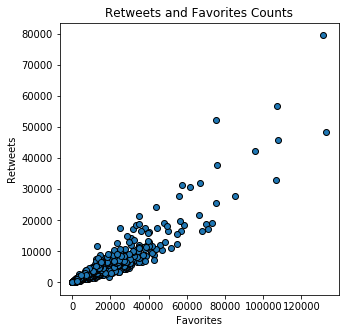

In [98]:
plt.subplots(figsize=(5, 5))
plt.scatter(df['favorite_count'], df['retweet_count'],edgecolors='black')
plt.xlabel('Favorites')
plt.ylabel('Retweets')
plt.title('Retweets and Favorites Counts')
plt.savefig('retweet_favorite.png');

This is a scatter plot that displays the relationship between retweet and favorite counts. It seems that there is a strong positive correlation between the two variables. Most of favorite counts varies between 0 and 40000, and for retweets most counts varies between 0 and 10000

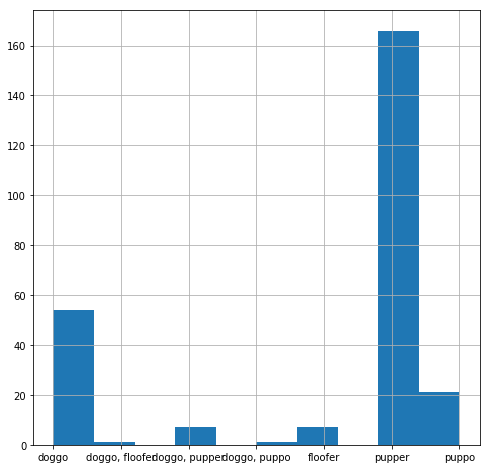

In [99]:
df['dog_stage'].hist(figsize=(8,8));

This is a histogram. It is showing that most of dog stage appearing in the data set is pupper, after pupper comes in second level doggo.